<a href="https://colab.research.google.com/github/JunSeokCheon/eCommerce_weblog_analysis/blob/master/eCommerce_weblog_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - 이번 프로젝트는 kaggle에서 제공하는 데이터셋인 eCommerce 웹 로그 데이터 분석 프로젝트이다.
### 1. 데이터 전처리
### 2. 데이터 분석 & 시각화
### 3. 데이터 모델링

#### 해당 파일은 xgboost를 사용한 고객 구매 정확도 모델을 만들것이다.
#### 가격과 브랜드를 포함한 여러한 피처들을 사용하여 고객이 결국 장바구니에 있는 항목을 구매할지 여부를 예측하는 파일이다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ecommerce_log_analysis

/content/drive/MyDrive/ecommerce_log_analysis


In [4]:
ls

2019-Nov.csv
2019-Oct.csv
data_load.ipynb
ecommerce-behavior-data-from-multi-category-store.zip
eCommerce_weblog_analysis.ipynb
eCommerce_weblog_modeling.ipynb
eCommerce_weblog_preprocessing.ipynb
eCommerce_weblog_RFManalysis.ipynb
kaggle.json
refined_2019_Oct.csv


## 데이터 load & import

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

%matplotlib inline

In [7]:
ecommerce_df = pd.read_csv("refined_2019_Oct.csv", index_col = 0)

In [8]:
ecommerce_df.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,kst_time
0,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01 09:00:00
1,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01 09:00:01
2,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01 09:00:04
3,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,2019-10-01 09:00:05
4,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,2019-10-01 09:00:10


## **모델링**
event_type이 cart인 제품을 고객이 구매할지 안할지 예측하는 모델링  

#### **피처 엔지니어링**
머신러닝 모델을 학습시키기 위해서 데이터를 재구조화합니다. 이떄 고객이 장바구니에 제품을 "cart" 데이터만 대상으로 합니다.



*   category_code_level1: 카테고리
*   category_code_level2: 하위 카테고리
*   event_weekday: 요일
*   activity_count: 세션 활동 수
*   is_purchased: cart 제품 구매 여부

train 데이터 세트에는 위에서 언급한 새로운 기능과 함께 중복되지 않은 모든 장바구니 트랜잭션이 포함합니다.   
원래 가격과 브랜드를 포함한 이러한 기능을 사용하여 고객이 결국 장바구니에 있는 항목을 구매할지 여부를 예측합니다.

### 데이터 엔지니어링 
1. event_type이 cart, purchase인 데이터를 대상으로 중복없이 추출한다.
2. event_type이 puchasedlaus 1, 아니면 0인 새로운 "is_purchased" 컬럼을 생성한다.
3. "user_session", "product_id"가 같다면 같은 제품에 대한 처리이기 때문에 하나라도 구입한 사례가 있으면 1로 처리한다.
4. 우리의 목표는 cart에 있는 항묵을 구매할지 여부를 예측하는 것이니 cart인 데이터를 대상으로 중복없이 추출한다.
5. "kst_time"에 weekday 함수를 사용해 요일을 추출해 새로운 "event_weekend" 컬럼을 생성한다.. (0-월 ~ 6-일)
6. 상위 카테고리와 하위 카테고리를 추출하기 위해 category_code에 split을 하고 category 타입으로 astype하여 추출해 새로운 컬럼들을 생성한다.

In [30]:
df_targets = ecommerce_df.loc[ecommerce_df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"] == "cart"].drop_duplicates(["user_session", "product_id", "is_purchased"])
df_targets['event_weekend'] = df_targets['kst_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets["category_code_level1"] = df_targets["category_code"].str.split(".", expand=True)[0].astype("category")
df_targets["category_code_level2"] = df_targets["category_code"].str.split(".", expand=True)[1].astype("category")

#### 세션 활동 수 컬럼 생성 방법
1. event_type이 cart와 purchase가 있는 user_id 데이터만 뽑는다.
2. user_session 별 그룹핑하여 evnet_type의 개수를 세면 해당 세션의 활동 수가 나온다.
3. event_type 명을 activity_count로 rename 한다.

In [41]:
cart_purchase_users = ecommerce_df[ecommerce_df["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset = ["user_id"])
cart_purchase_users_al_activity = ecommerce_df.loc[ecommerce_df['user_id'].isin(cart_purchase_users['user_id'])]
activity_in_session = cart_purchase_users_al_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

새롭게 만든 컬럼들이 있는 데이터프레임과 세션 활동 수 컬럼의 데이터프레임을 merge 한다.

In [42]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)

In [43]:
df_targets.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,kst_time,is_purchased,event_weekend,category_code_level1,category_code_level2,activity_count
0,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,2019-10-01 09:09:33,1,1,electronics,smartphone,4
1,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,2019-10-01 09:11:00,0,1,electronics,audio,4
2,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,2019-10-01 11:17:59,0,1,electronics,smartphone,7
3,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,2019-10-01 11:19:36,1,1,electronics,smartphone,16
4,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,2019-10-01 11:19:43,1,1,electronics,smartphone,10


In [44]:
df_targets.to_csv('training_data.csv')

#### resampling 진행
- training set에서 반복해서 sample을 뽑고, 거기에 반복에서 model을 적합시켜 볼 것이다.

In [47]:
is_purchase_set = df_targets[df_targets['is_purchased'] == 1]
is_purchase_set.shape

(273909, 14)

In [48]:
not_purchase_set = df_targets[df_targets['is_purchased'] == 0]
not_purchase_set.shape

(272691, 14)

In [49]:
n_samples = 200000
is_purchase_sample = resample(is_purchase_set, replace=False, n_samples=n_samples, random_state=27)
not_purchase_sample = resample(not_purchase_set, replace=False, n_samples=n_samples, random_state=27)

In [50]:
sampled = pd.concat([is_purchase_sample, not_purchase_sample])
sampled['is_purchased'].value_counts()

1    200000
0    200000
Name: is_purchased, dtype: int64

In [66]:
features = sampled.loc[:,['brand', 'price', 'event_weekend', 'category_code_level1', 'category_code_level2', 'activity_count']]

In [67]:
features.head()

,brand,price,event_weekend,category_code_level1,category_code_level2,activity_count
153655,apple,160.88,5,electronics,audio,4
129910,xiaomi,98.84,3,electronics,smartphone,15
352658,turbo,154.42,0,appliances,kitchen,4
168343,samsung,285.40,6,electronics,smartphone,5
534231,samsung,362.74,3,electronics,smartphone,14


#### 카테고리 컬럼들 encode
모델을 학습시키 위해 컬럼들의 값들이 숫자형으로 인코딩하는 작업이 요구된다.  
카테고리 데이터들을 인코딩하는 간단한 방법인 labelencoder를 사용할 것이다.

In [68]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(sampled.loc[:,'brand'].copy())
features.loc[:,'event_weekend'] = LabelEncoder().fit_transform(sampled.loc[:,'event_weekend'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(sampled.loc[:,'category_code_level1'].copy())
features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(sampled.loc[:,'category_code_level2'].copy())

is_purchased = LabelEncoder().fit_transform(sampled['is_purchased']) # 정답 배열 - 구입 여부

In [69]:
features.head()

,brand,price,event_weekend,category_code_level1,category_code_level2,activity_count
153655,20,160.88,5,7,1,4
129910,349,98.84,3,7,27,15
352658,331,154.42,0,2,19,4
168343,285,285.40,6,7,27,5
534231,285,362.74,3,7,27,14


In [70]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 153655 to 25960
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   brand                 400000 non-null  int64  
 1   price                 400000 non-null  float64
 2   event_weekend         400000 non-null  int64  
 3   category_code_level1  400000 non-null  int64  
 4   category_code_level2  400000 non-null  int64  
 5   activity_count        400000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 21.4 MB


#### 데이터 분리

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, is_purchased, test_size = 0.3, random_state = 0)

#### 모델 학습

In [72]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate = 0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

Accuracy: 0.6120833333333333
Precision: 0.5939353357566481
Recall: 0.7208033433944742
fbeta: 0.6113485789789493


#### 피처 중요도

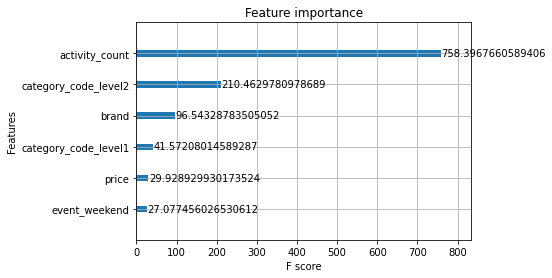

In [74]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()